<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Polynomial Regression and Regularization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Auto.csv':'https://storage.googleapis.com/aipi_datasets/Auto.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

## Polynomial Regression
To easily implement polynomial regression in Scikit Learn we can use the PolynomialFeatures class to transform our input data to any degree

In [3]:
# Example of using PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
x = np.array([[2], [3], [4]])
poly = PolynomialFeatures(3, include_bias=True)
poly.fit_transform(x)

array([[ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

In [4]:
def load_data(filename):
    # Read in data
    data = pd.read_csv(filename)
    # Remove rows with missing values
    data = data[data['horsepower'] != '?']
    return data

data = load_data('Auto.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [5]:
def prep_data(data,pct):
    # Define the features and response (X and y)
    X = data['horsepower'].astype(int).values.reshape(-1,1)
    y = data['mpg'].astype(float)

    # Split into training and test sets
    X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=pct)
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = prep_data(data,pct=0.2)

MSE train: 24.430, test: 22.026


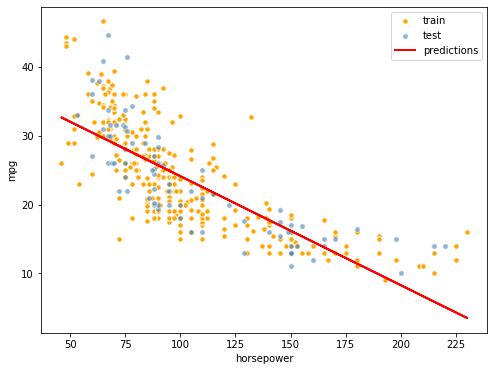

In [6]:
def run_lr(X_train,y_train,X_test):
    # Let's use a Simple Linear Regression model
    model = LinearRegression()

    # Train the model on the training data
    model.fit(X_train,y_train)

    # Get the predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    return train_preds, test_preds, model

train_preds, test_preds, model = run_lr(X_train,y_train,X_test)

# Calculate MSE
train_mse = 1/len(y_train)*np.sum((train_preds-y_train)**2)
test_mse = 1/len(y_test)*np.sum((test_preds-y_test)**2)
print('MSE train: {:.3f}, test: {:.3f}'.format(train_mse,test_mse))

# Look at how well the model is fitting the data
plt.figure(figsize=(8,6))
plt.scatter(X_train,y_train,color='orange',edgecolor='white',s=30,label='train') # Plot training data
plt.scatter(X_test,y_test,color='steelblue',edgecolor='white',s=30,alpha=0.6,label='test') # Plot test data
plt.plot(X_train,train_preds,color='red',lw=2,label='predictions') # Plot predictions
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.legend()
plt.show()

While our model appears to do an ok job fitting the data, we can see that there is room for improvement.  There appears to be a non-linear relationship between horsepower and mpg.  Let's use a polynomial regression to see if we can improve the model

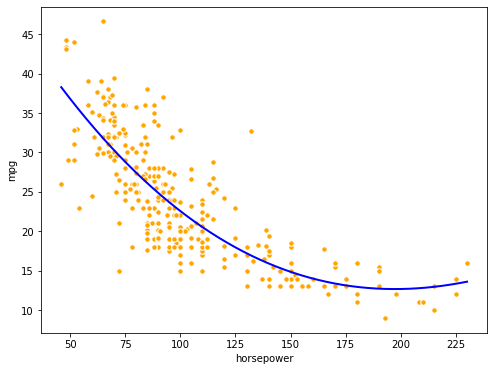

MSE train: 19.728, test: 15.911


In [7]:
def train_poly(X_train,y_train,degree):
    # Create polynomial features and trains a linear model on them

    # Instantiate the polynomial transformation
    poly_transform = PolynomialFeatures(degree=degree)

    # Apply the transformation to the training and test sets
    X_train_poly = poly_transform.fit_transform(X_train)

    # Fit model to transformed X_train
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly,y_train)

    return poly_transform, poly_model

def test_model(model, X_test, y_test,transform=None):
    # Compute the MSE for a model
    if transform is not None:
        X_test = transform.transform(X_test)
    preds = model.predict(X_test)
    mse = 1/len(y_test)*np.sum((preds-y_test)**2)
    return mse

degree=3
poly_transform, model = train_poly(X_train,y_train,degree)
train_mse = test_model(model, X_train, y_train, poly_transform)
test_mse = test_model(model, X_test, y_test, poly_transform)

# Look at how well the model is fitting the data
plt.figure(figsize=(8,6))
plt.scatter(X_train,y_train,color='orange',edgecolor='white',s=30,label='train') # Plot training data

# Plot the predictions from the polynomial model
x_plot = np.linspace(X_train.min(),X_train.max()).reshape(-1,1)
preds_plot = model.predict(poly_transform.transform(x_plot))
plt.plot(x_plot,preds_plot,color='blue',lw=2,label='Polynomial model preds') 
# plt.plot(x_plot,model.predict(x_plot),color='red',lw=2,label='Linear predictions') # Plot predictions

plt.xlabel('horsepower')
plt.ylabel('mpg')
#plt.title('Polynomial regression model, degree = {}'.format(i))
#plt.legend()
plt.show()

print('MSE train: {:.3f}, test: {:.3f}'.format(train_mse,test_mse))

## LASSO Regression
Let's use LASSO Regression to add regularization and see what impact it has on the features included in the model.  First we will run a standard linear regression to get a baseline.

In [8]:
def prep_data_allfeats(data,pct):
    # Define the features and response (X and y)
    X = data[['cylinders','displacement','horsepower','weight','acceleration','year']].astype(int)
    y = data['mpg'].astype(float)

    # Split into training and test sets
    X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=pct)
    return X_train,X_test,y_train,y_test

def test_model(model, X_test, y_test,transform=None):
    # Compute the MSE for a model
    if transform is not None:
        X_test = transform.transform(X_test)
    preds = model.predict(X_test)
    mse = 1/len(y_test)*np.sum((preds-y_test)**2)
    return mse

# Split our data and run the model
X_train,X_test,y_train,y_test = prep_data_allfeats(data,pct=0.2)
train_preds, test_preds, model = run_lr(X_train,y_train,X_test)

# Calculate MSE
train_mse = test_model(model,X_train,y_train)
test_mse = test_model(model,X_test,y_test)
print(model)
print('MSE train: {:.3f}, test: {:.3f}'.format(train_mse,test_mse))

LinearRegression()
MSE train: 11.539, test: 11.953


Now let's try a LASSO model.  First we need to scale our data

MSE on the test set is 13.124
y = 23.482 + -0.000*cylinders + -0.000*displacement + -0.094*horsepower + -4.790*weight + 0.000*acceleration + 1.951*year


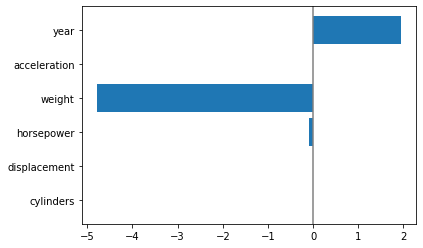

In [9]:
def train_lasso(X_train,y_train,alpha=1.):
    # First we scale our data - remember, only use the training data to fit the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Run a LASSO model
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled,y_train)
    return scaler,lasso_model
    
scaler,model = train_lasso(X_train,y_train)
test_mse = test_model(model, X_test, y_test,transform=scaler)
print('MSE on the test set is {:.3f}'.format(test_mse))

# Display the equation for the LASSO model
coef = model.coef_
intercept = model.intercept_
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X_train.columns)])
print(equation)

# Plot the coefficients
plt.barh(X_train.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()

As we can see above, our LASSO model at lambda/alpha=1.0 zeroed out several of our model coefficients, leaving only weight, horsepower, and year in our model.

## Ridge Regression

MSE on the test set is 11.917
y = 23.482 + -0.403*cylinders + 0.567*displacement + 0.095*horsepower + -5.728*weight + 0.380*acceleration + 2.692*year


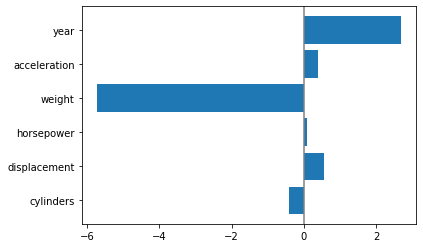

In [10]:
def train_ridge(X_train,y_train,alpha=1.0):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Run a Ridge model using the default lambda (alpha)
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled,y_train)
    
    return scaler, ridge_model

scaler,model = train_ridge(X_train,y_train)
test_mse = test_model(model, X_test, y_test, transform=scaler)
print('MSE on the test set is {:.3f}'.format(test_mse))

# Display the equation for the LASSO model
coef = model.coef_
intercept = model.intercept_
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X_train.columns)])
print(equation)

# Plot the coefficients
plt.barh(X_train.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()